# Rocket Control with JuMP

<img src="https://upload.wikimedia.org/wikipedia/commons/7/7c/Goddard_and_Rocket.jpg" width="50%">

> Robert Hutchings Goddard was an American engineer, professor, physicist, and inventor who is credited with creating and building the world's first liquid-fueled rocket which he successfully launched on March 16, 1926. Goddard and his team launched 34 rockets between 1926 and 1941, achieving altitudes as high as 2.6 km (1.6 mi) and speeds as high as 885 km/h (550 mph).

*From [Wikipedia](https://en.wikipedia.org/wiki/Robert_H._Goddard)*

*This problem was drawn from the [COPS3](http://www.mcs.anl.gov/~more/cops/cops3.pdf) benchmark.*

## Simple Rocket Flight Model

Before we even talk about optimization, we will create a simple model of a rocket in flight: state variables, controls, and dynamics.

### State variables

We will take a very simplified view and consider everything to be one-dimensional: our rocket will go straight up (and straight down). So our first two state variables that vary across time are 

* **velocity**, $v(t)$
* **altitude**, $h(t)$

Our rocket is burning fuel as it goes, getting lighter and lighter in the process. Therefore we need a third state variable

* **Mass of rocket and remaining fuel**, $m(t)$

We will start at altitude $h_0$, velocity 0, and mass $m_0$. We will define $m_c$ to be fraction of rocket that is the rocket itself. $m(t)$ is thus $\geq m_c m_0$.

### Control

We will have one control for our rocket: the **thrust** $T(t)$. We will assume that it can be changed rapidly, which is not completely unreasonable for a liquid-fuel rocket. There is however a maximum thrust of $T_{max}$.

### Dynamics

We need to consider what forces act on our rocket other than thrust. The most obvious perhaps is **gravity**

$$g(h) = g_0 \left( \frac{h(0)}{h} \right)^2$$

which is a function of height. The other key force is **drag**

$$D(h,v) = D_c v^2 exp\left( -h_c \left( \frac{h-h(0)}{h(0)} \right) \right)$$

which is a complicated function of velocity (squared), height (to adjust for air density), and a drag coefficient $D_c$ determined by the rocket shape.

Given all the above, we can link together everything with three equations to control the dynamics of the rocket:

* **Rate of ascent** $$h^\prime = v$$
* **Acceleration** $$v^\prime = \frac{T - D(h,v)}{m} - g(h)$$
* **Rate of mass loss** $$m^\prime = -\frac{T}{c}$$

where $c$ is a constant measuring the impulse of the rocket fuel.

## Optimization problem

The goal is **maximize the final altitude of our rocket**. The only thing we can change, other than the rocket properties itself, are the way we vary our thrust over time. We will formulate an optimization problem to find the optimal thrust profile.

### Dealing with time

We will use a **discretized model of time**, with a fixed number of time steps, $n$. We will make the time step size $\Delta t$, and thus the final time $t_f = n \cdot \Delta t$, a variable in the problem. We can now write out objective as
$$
\max h(t_f)
$$

Given this, we now need to discretize our dynamic equations. For example, how do we relate $v(t)$ and $v(t+\Delta t)$? To do so we will use numerical integration. One simple idea is the "rectangular rule", e.g.
$$
f(t+\Delta t) - f(t) = \Delta t v(t)
$$

We will use the more accurate but more complicated [trapezoidal rule](http://en.wikipedia.org/wiki/Trapezoidal_rule) (other options are possible!). In particular, in the context our problem we have that
$$
f(t+\Delta t) - f(t) = \frac{ v(t + \Delta t) + v(t) }{ 0.5 \Delta t }
$$

The three equations that relate the states, controls, and forces correspond to **constraints** in the optimization problem.

### Data

For the purposes of this example we will use dimension free (scaled) parameters. In particular:

* $T_{max} = 3.5 g_0 m_0$
* $D_c = 0.5 v_c \frac{m_0}{g_0}$
* $c = 0.5 (g_0 h_0 )^{0.5}$
* So $h_0 = m_0 = g_0 = 1$
* and we choose $h_c = 500$, $m_c = 0.6$, $v_c = 620$

Finally we will use $n$ time steps.

### Initial Solution

We will be using an *interior point* solver. You can think of it as basically a gradient descent inside the space of feasible solutions. We can help out the solver by providing a good initial solution that is not wildly different from the final solution. We'll use the following solution:

* $t_f = n \Delta t = 1$
* $h(t) = 1$
* $v(t) = \frac{t}{t_f}(1 - \frac{t}{t_f})$
* $m(t) = (m_f - m_0)\frac{t}{t_f} + m_0$

## Building the model

In [2]:
# Load JuMP, and a nonlinear solver Ipopt
# Other options we have for this problem class
# is KNITRO.jl, a commercial solver.
using JuMP, Ipopt

In [13]:
# Create JuMP model, using Ipopt as the solver
#mod = Model(solver=IpoptSolver(print_level=0))
mod = Model(solver=IpoptSolver())

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver set to Ipopt

In [14]:
# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

# Parameters
T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

# Derived parameters
c     = 0.5*sqrt(g_0*h_0)  # Thrust-to-fuel mass
m_f   = m_c*m_0            # Final mass
D_c   = 0.5*v_c*m_0/g_0    # Drag scaling
T_max = T_c*g_0*m_0        # Maximum thrust

# Time steps
n = 800

800

In [15]:
# Set up variables and constraints

# Time step with initial guess
@defVar(mod, Δt ≥ 0, start = 1/n)
# Store a useful subexpression, "time of flight"
@defNLExpr(t_f, Δt*n)

# State variables
@defVar(mod, v[0:n] ≥ 0)            # Velocity
@defVar(mod, h[0:n] ≥ h_0)          # Height
@defVar(mod, m_f ≤ m[0:n] ≤ m_0)    # Mass

# Control: thrust
@defVar(mod, 0 ≤ T[0:n] ≤ T_max)

# Provide starting solution
# Could have done this at same time as @defVar
for k in 0:n
    setValue(h[k], 1)
    setValue(v[k], (k/n)*(1 - (k/n)))
    setValue(m[k], (m_f - m_0)*(k/n) + m_0)
    setValue(T[k], T_max/2)
end

# Objective: maximize altitude at end of time of flight
@setObjective(mod, Max, h[n])

# Initial conditions
@addConstraint(mod, v[0] == v_0)
@addConstraint(mod, h[0] == h_0)
@addConstraint(mod, m[0] == m_0)
@addConstraint(mod, m[n] == m_f)

# Forces
# We'll define these as expressions too
# Wherever they appear, they will effectively be
# replaced by these longer expressions, keeps them
# nice and clean

# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@defNLExpr(drag[j=0:n], D_c*(v[j]^2)*exp(-h_c*(h[j]-h_0)/h_0))
# Grav(h)   = g0 * (h0 / h)^2
@defNLExpr(grav[j=0:n], g_0*(h_0/h[j])^2)

# Dynamics
for j in 1:n
    # h' = v
    # Rectangular integration
    # @addNLConstraint(mod, h[j] == h[j-1] + Δt*v[j-1])
    # Trapezoidal integration
    @addNLConstraint(mod,
        h[j] == h[j-1] + 0.5*Δt*(v[j]+v[j-1]))

    # v' = (T-D(h,v))/m - g(h)
    # Rectangular integration
    # @addNLConstraint(mod, v[j] == v[j-1] + Δt*(
    #                 (T[j-1] - drag[j-1])/m[j-1] - grav[j-1]))
    # Trapezoidal integration
    @addNLConstraint(mod,
        v[j] == v[j-1] + 0.5*Δt*(
            (T[j  ] - drag[j  ] - m[j  ]*grav[j  ])/m[j  ] +
            (T[j-1] - drag[j-1] - m[j-1]*grav[j-1])/m[j-1] ))

    # m' = -T/c
    # Rectangular integration
    # @addNLConstraint(mod, m[j] == m[j-1] - Δt*T[j-1]/c)
    # Trapezoidal integration
    @addNLConstraint(mod,
        m[j] == m[j-1] - 0.5*Δt*(T[j] + T[j-1])/c)
end

In [16]:
# Solve for the control and state
println("Solving...")
status = solve(mod)

# Display results
println("Solver status: ", status)
println("Max height: ", getObjectiveValue(mod))

Solving...
This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    15204
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    48800

Total number of variables............................:     3205
                     variables with only lower bounds:     1603
                variables with lower and upper bounds:     1602
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2404
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

In [17]:
# Can visualize the state and control variables
using Gadfly

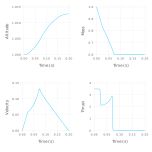

In [18]:
h_plot = plot(x=(0:n)*getValue(Δt),y=getValue(h)[1:n], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = plot(x=(0:n)*getValue(Δt),y=getValue(m)[1:n], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = plot(x=(0:n)*getValue(Δt),y=getValue(v)[1:n], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = plot(x=(0:n)*getValue(Δt),y=getValue(T)[1:n], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack( hstack(h_plot,m_plot),
                                hstack(v_plot,T_plot)))